In [1]:
#| hidden: true
#| echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# some personal style settings to make the plots look nice
# and save some space in the notebook
plt.style.use("../style.mplstyle")

## Data Generating Processes

In the previous lecture we saw examples of running simulations to generate data, whether by simply drawing samples from a probability distribution (i.e. flipping coins / rolling dice) or by simulating a complex process explicitly (the busking musician example). 

This leads us to a useful way of thinking about data: **all data is generated by some underlying process**. The process can be simple or complex, deterministic or stochastic, observed or unobserved, but it is always there. If that sounds obvious, it is because it is! "Some process" is a bit of a catch-all: of course the data doesn't just appear out of nowhere. However, it is also important to keep in mind because, as we will see, thinking about **data generating processes** (DGPs) is the key to analyzing data.


## Statistical Models
A **statistical model** is a formal mathematical representation of a data generating process. Specifically, it describes the probability distribution of the data. Based on the model, we can make precise statements about the data generated by the process. For example, we can say how likely it is to observe a certain value or set of values. We can tell what the average (or expected) value is, what the most likely value is, and so on.

Let's return to coin flips once again. The data generating process is the flipping of a coin, which has two possible outcomes: heads or tails. The statistical model for this process is a **Bernoulli distribution**, which describes the probability of each outcome. Specifically, 

$$P(X) = \begin{cases}
p & \text{if } X = 1 ~\text{heads} \\
1 - p & \text{if } X = 0 ~\text{tails}
\end{cases}$$

where \(X\) is the outcome of the coin flip, \(p\) is the probability of heads, and \(1 - p\) is the probability of tails. If we assume a fair coin, then \(p = 0.5\).

Now clearly, this model does not capture the complexity of a real-world coin flip, which is of course influenced by many factors such as the weight of the coin, the force of the flip, air resistance, etc. Statistical models are always reductive in this sense. But the important thing is that a Bernoulli distribution really does do a good job of describing the **outcomes** of a coin flip. As long as that is the case, we can use the model to make predictions about the data generated by the process.

To see this, consider the following process: you roll a fair die 100 times. For each roll, you record whether the number you rolled was even or odd. Since there are three even numbers (2, 4, 6) and three odd numbers (1, 3, 5), and each number has an equal probability of being rolled, the probability of rolling an even number is 0.5 and the probability of rolling an odd number is also 0.5. This is statistically identical to flipping a fair coin! So we can use the same Bernoulli distribution to model the outcomes of this process, even though it completely ignore the details of the die rolling process itself. We lose information about the specific numbers rolled, but as long as we accurately capture the probability of the outcomes we care about, it doesn't matter.



<!-- Think back to Lecture 00, where we analyzed a dataset of Airbnb listings.  -->

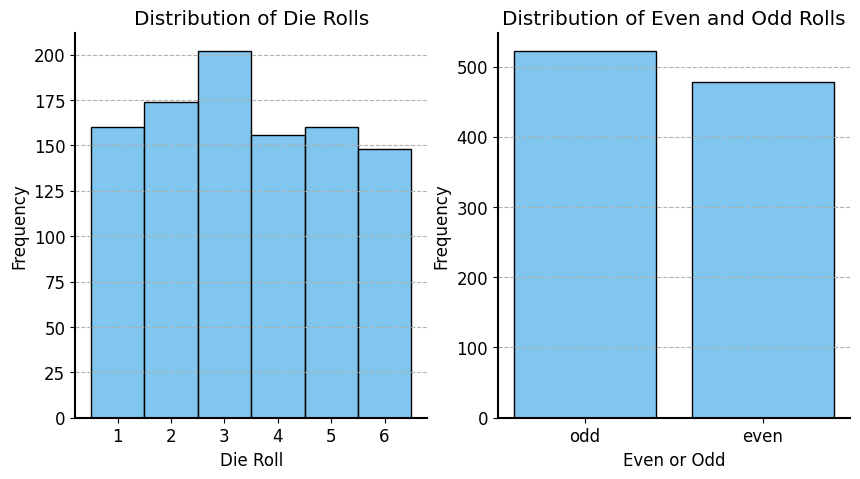

In [2]:
def dice_even_odd(n=1000):
    """
    Simulate rolling a die n times and return the results.
    
    Parameters:
    n (int): Number of rolls to simulate.
    
    Returns:
    pd.DataFrame: DataFrame with columns 'roll' and 'even_odd'.
    """
    rolls = np.random.randint(1, 7, size=n)
    is_even = rolls % 2 == 0
    return pd.DataFrame({"roll": rolls, "is_even": is_even, "even_odd": np.where(is_even, "even", "odd")})

dice_rolls = dice_even_odd(1000)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(dice_rolls["roll"], bins=np.arange(1, 8) - 0.5, discrete=True, ax=ax[0])
ax[0].set_xlabel("Die Roll")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Distribution of Die Rolls")
ax[0].set_xticks(np.arange(1, 7))
ax[0].grid(axis='y')

sns.histplot(dice_rolls["even_odd"], discrete=True, shrink=0.8, ax=ax[1])
ax[1].set_xlabel("Even or Odd")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Distribution of Even and Odd Rolls")
ax[1].grid(axis='y')
plt.show()

Statistical modeling generally uses this kind of trick. We attempt to find a simple model that captures the essential features of the data generating process. 

We don't always know as much about the data generating process as we do for a coin flip or a die roll. In fact, often we don't know anything about it at all! In these cases, the approach is a little more "guess and check". 
We start with a simple model, and see how well it describes the data. If it doesn't work, we try a more complex model or a different model altogether. 

### Challenges with finite samples
It can be hard to tell if you have a good model or not. With any finite dataset, it is quite likely that the data will not perfectly match the model. This is because the model describes probabilistic *tendencies* of the data. But in any small sample we will likely see deviations from the idealized outcomes described by the model. 

Think about this in the extreme: if you flip a coin only once, you will either get heads or tails. So your observed proportion of heads will be either 0 or 1, which is very different from the expected proportion of 0.5. In fact it is impossible to observe the expected proportion of heads in a single flip!
This is true for a single observation of basically any random variable that takes on more than one value -- it is close to impossible to learn anything about the variable's tendencies from just one observation. 

Even with a small number of observations, it is quite difficult to tell if a model is a good fit for the data. 

Let's say you and your roommate are always arguing about who should take out the trash. You decide to flip a coin to decide who takes it out (you are notorious for always choosing tails, because you think it's good luck). You decide to do a best-of-ten series, so you flip the coin 10 times and record the number of heads. It turns out that you get 3 heads and 7 tails. Your roommate is *furious*: "That's not fair! You always get tails! I bet you rigged the coin!"

Is your roommate justified in being suspicious? What is the probability of getting 3 heads in 10 flips of a fair coin? What is the probability of getting 3 heads in 10 flips of a biased coin that has a 25\% chance of landing on heads?


In [3]:
#| echo: false
from jupyterquiz import display_quiz
quiz_content = [
    {
        "question": "What is the probability of getting 3 heads in 10 flips of a fair coin?",
        "type": "numeric",
        "precision": 4,
        "answers": [
            {
                "type": "range",
                "range": [0.116, 0.118],
                "correct": True,
                "feedback": "Correct! The probability is (0.5)^3 * (1-0.5)^7 * 120 = 0.1172",
            },
            {
                "type": "default",
                "feedback": "Incorrect.",
            },
        ],
    },
    {
        "question": "What is the probability of getting 3 heads in 10 flips of a biased coin? (25% chance of heads)",
        "type": "numeric",
        "precision": 4,
        "answers": [
            {
                "type": "range",
                "range": [0.24, 0.26],
                "correct": True,
                "feedback": r"Correct! The probability is $(0.25)^3 \cdot (1-0.25)^7 \cdot 120 = 0.2503$",
            },
            {
                "type": "default",
                "feedback": "Incorrect.",
            },
        ],
    },
    {
        "question": "What is the probability of getting 30 heads in 100 flips of a fair coin?",
        "type": "numeric",
        "precision": 4,
        "answers": [
            {
                "type": "range",
                "range": [2e-5, 3e-5],
                "correct": True,
                "feedback": r"Correct! The probability is $(0.5)^{30} * (1-0.5)^{70} * {100 \choose 30} =2.317 \times 10^{-5}$",
            },
            {
                "type": "default",
                "feedback": "Incorrect.",
            },
        ],
    },
    {
        "question": "What is the probability of getting 30 heads in 100 flips of a biased coin? (25% chance of heads)",
        "type": "numeric",
        "precision": 4,
        "answers": [
            {
                "type": "range",
                "range": [0.04, 0.05],
                "correct": True,
                "feedback": r"Correct! The probability is $(0.25)^{30} \cdot (1-0.25)^{70} \cdot {100 \choose 30} = 0.0458$",
            },
            {
                "type": "default",
                "feedback": "Incorrect.",
            },
        ],
    },
]
display_quiz(quiz_content)


<IPython.core.display.Javascript object>

As this exercise shows, with a small number of observations you have *some* information that can help you distinguish between the two models, but it is not enough to be confident in your conclusion. 

With more data though, suddenly the evidence becomes much stronger. The probability of getting a badly imbalanced distribution of heads and tails becomes tiny as the number of flips increases.

In general this is great news -- the more data you have, the more confident you can be in your conclusions. It's probably not worth flipping a coin 1000 times to decide who takes out the trash, but if you did, you would be able to tell with much more certainty whether the coin is fair or not.

## Convergence for large sample sizes
When the size of a dataset is large enough, we get some guarantees.

### Law of Large Numbers
The Law of Large Numbers (LLN) states that as the sample size increases, the sample mean will converge to the population mean. In other words, if we take enough samples, the average of those samples will be close to the true average of the population.

::: {.callout-note title="Law of Large Numbers" collapse="false"}
Let $X_1, X_2, \ldots, X_n$ be independent and identically distributed random variables with expected value $\mathbb{E}[X]$, then the sample mean $\bar{X}_n = \frac{1}{n} \sum_{i=1}^{n} X_i$ converges to $\mathbb{E}[X]$ as $n$ approaches infinity:
$$\mathbb{P} \left[\lim_{n \to \infty} \bar{X}_n = \mathbb{E}[X]\right] = 1$$

Precisely, this states that the probability that the sample mean converges to the population mean is 1. 
^[
This is technically the *Strong Law of Large Numbers*, stating that the sample mean converges almost surely to the population mean. There is also a *Weak Law of Large Numbers* which states that the sample mean converges in probability to the population mean, which is a weaker condition.
]
:::

You don't just have to take this for granted -- let's see the LLN in action. 

We will simulate flipping a biased coin $n$ times, and plot the proportion of heads as we increase the number of flips. We will see that the proportion converges to 0.25 as the number of flips increases.

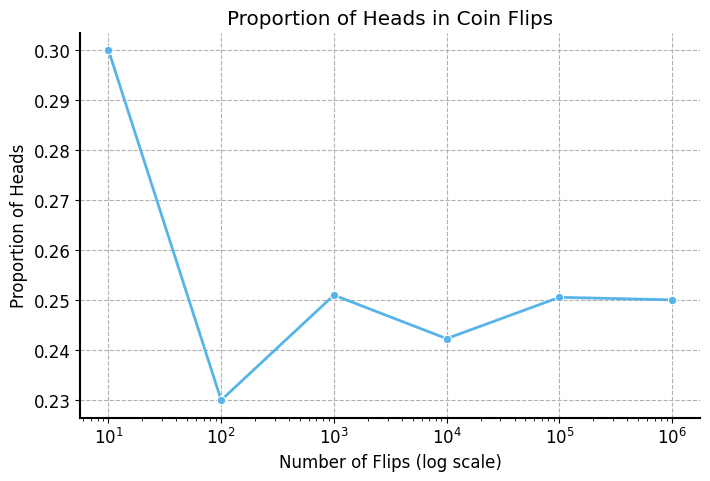

In [38]:
# set seed
np.random.seed(56)
# flip a fair coin n times
samples_sizes = [10, 100, 1000, 1e4, 1e5, 1e6]
proportion_heads = []
for n in samples_sizes:
    # Simulate flipping a fair coin n times
    flips = np.random.binomial(1, 0.25, size=int(n))
    proportion_heads.append(np.mean(flips))
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x=samples_sizes, y=proportion_heads, marker='o', ax=ax)
ax.set_xscale('log')
ax.set_xlabel("Number of Flips (log scale)")
ax.set_ylabel("Proportion of Heads")
ax.set_title("Proportion of Heads in Coin Flips")
ax.grid(True)
plt.show()

That's just one experiment (flip $n$ coins a single time). But this is a random process, so we can simulate it many times
and see how the proportion of heads changes. 

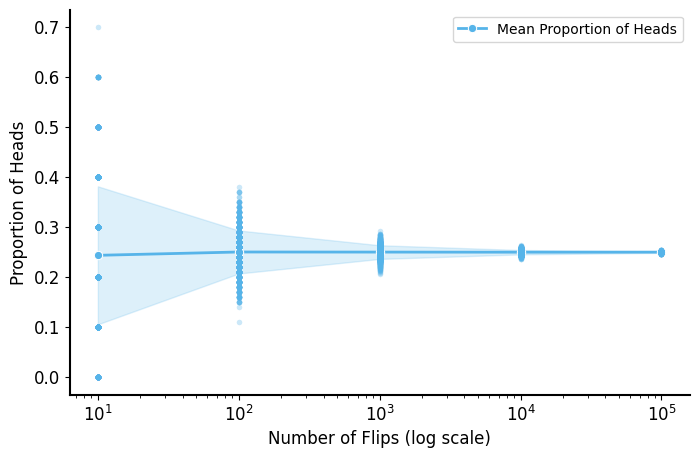

In [41]:
np.random.seed(56)
samples_sizes = [10, 100, 1000, 1e4, 1e5]
sim_results = []

for n in samples_sizes: # outer loop is over sample size
    for _ in range(1000):  # inner loop runs the simulation 1000 times, for each sample size
        # sample n flips from a fair coin
        flips = np.random.binomial(1, 0.25, size=int(n))
        # calculate the proportion of heads
        proportion_heads = np.mean(flips)
        # store the result
        sim_results.append(pd.Series({"n": n, "proportion_heads": proportion_heads}))
# gather all the results (a list of Series) into a DataFrame
sim_results = pd.concat(sim_results, axis=1).T

fig, ax = plt.subplots(figsize=(8, 5))
# plot the proportion from individual simulations as points
sns.stripplot(data=sim_results, 
              x="n", y="proportion_heads", 
              jitter=False, alpha=0.3, ax=ax, native_scale=True, marker='o', size=4)
# plot the mean proportion of heads across simulations
sns.lineplot(data=sim_results, 
             x="n", y="proportion_heads", 
             errorbar="sd", marker='o', ax=ax, 
             label='Mean Proportion of Heads')
# make ticks nicer
ax.set_xticks([10, 100, 1000, 10000, 100000])
ax.set_xscale('log')
ax.set_xlabel("Number of Flips (log scale)")
ax.set_ylabel("Proportion of Heads")
plt.show()

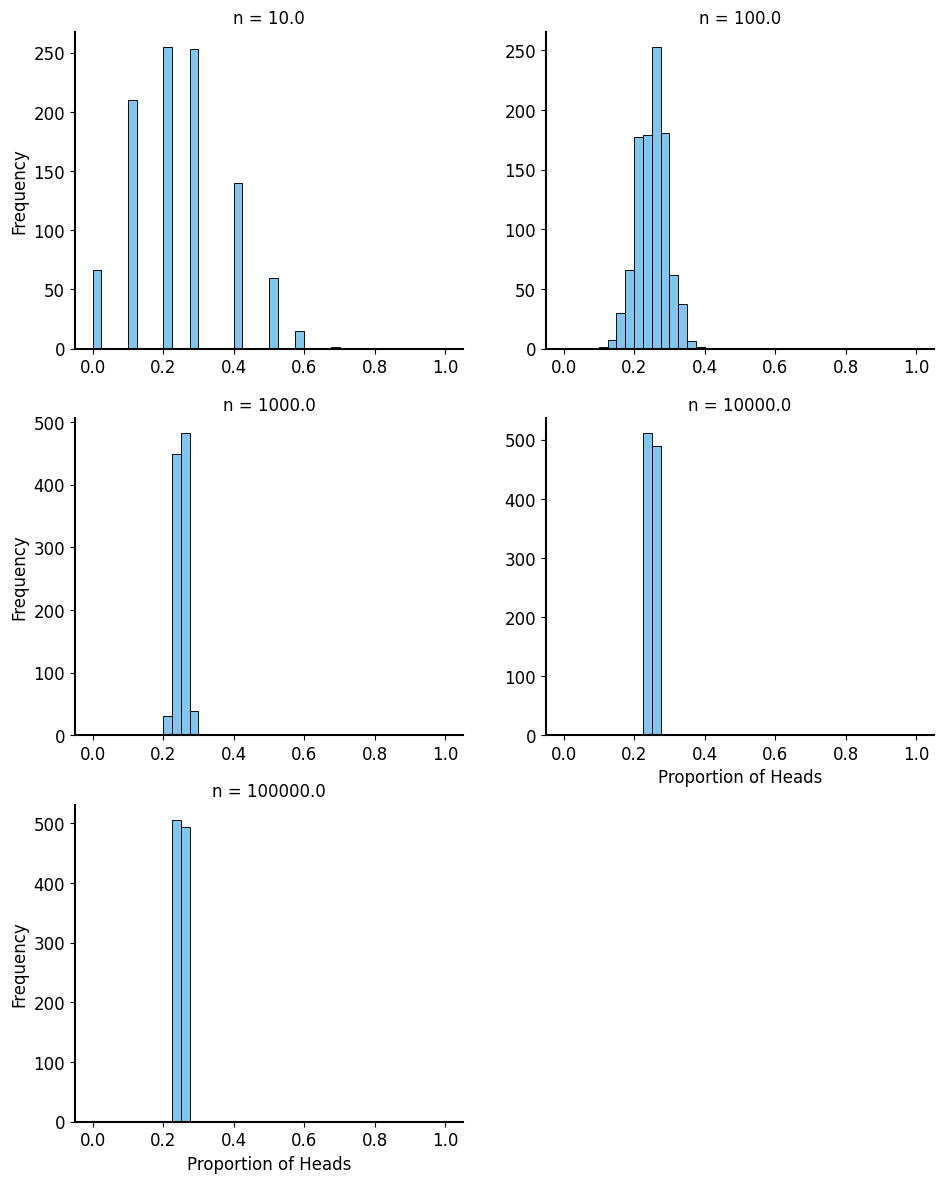

In [55]:
# histogram of the proportion of heads for each sample size
sns.FacetGrid(sim_results, col="n", col_wrap=2, height=4, aspect=1.2, sharex=False, sharey=False) \
    .map(sns.histplot, "proportion_heads", bins=np.linspace(0, 1, 41)) \
    .set_axis_labels("Proportion of Heads", "Frequency")

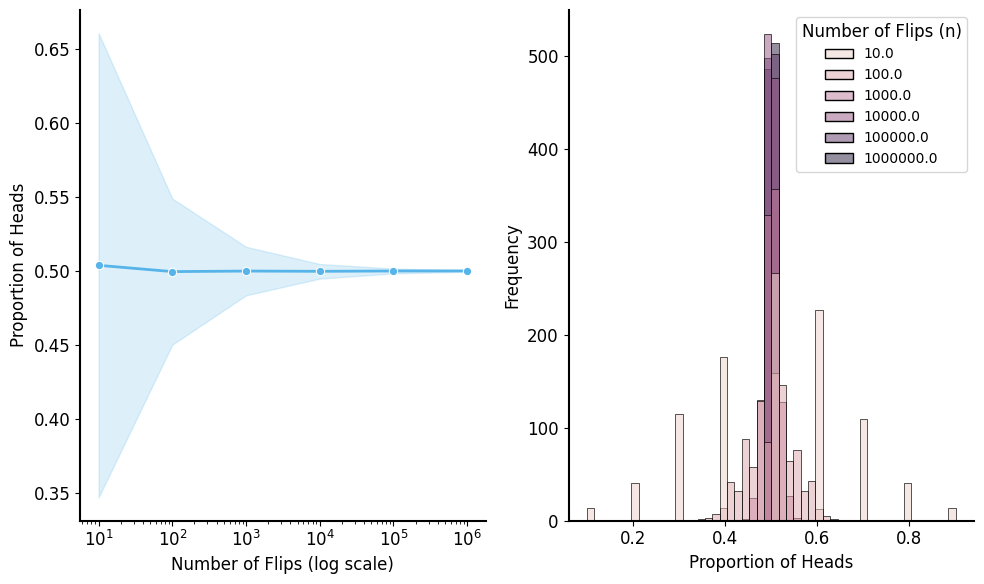

In [35]:
#| echo: false
#| hidden: true
#| eval: false
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.lineplot(x="n", y="proportion_heads", data=sim_results, ax=ax[0], errorbar="sd", marker='o')
ax[0].set_xscale('log')
ax[0].set_xlabel("Number of Flips (log scale)")
ax[0].set_ylabel("Proportion of Heads")

from matplotlib.colors import LogNorm
# Plotting the histogram with a logarithmic color scale
sns.histplot(data=sim_results, x="proportion_heads", hue="n", bins=50, multiple="layer", hue_norm=LogNorm(), ax=ax[1])
ax[1].set_xlabel("Proportion of Heads")
ax[1].set_ylabel("Frequency")
sns.move_legend(ax[1], "upper right", title="Number of Flips (n)")

plt.tight_layout()
plt.show()

As you can see, the variability across simulations decreases as the number of flips increases. This is what we mean when we say that the sample mean converges to the population mean. It's not just close to the true mean on average, it is also more consistent across different samples/simulations.

We're going to take advantage of this fact all the time. Basically any time you compare groups, or competing hypotheses, or evaluate predictive models, you end up taking the average of some quantity. The Law of Large Numbers tells us that as the sample size increases, the average will converge to the true value.

Again, what does this mean for your argument with your roommate? As you gather more and more data (coin flips), the proportion of heads (which is itself a sample mean) will converge to the true proportion of heads (the population mean). With enough flips, it becomes very clear whether the coin is rigged or not.

:::{.callout-note title="Unbiased Estimators"}
Notice in the simulation above that even when the sample mean was highly variable in small samples, it was always still centered around the true population mean. This is a crucial property for any estimator: it is said to be **unbiased** if the expected value of the estimator is equal to the true value of the parameter being estimated. In other words, on average, the estimator will give you the correct answer.

The LLN gives you a different guarantee: that as the sample size increases, the *variance* of the estimator decreases, so it becomes more and more likely that the estimator will be close to the true value.
:::

### Central Limit Theorem
The Central Limit Theorem states that the sample mean of $n$ independent and identically distributed random variables will converge to a normal distribution, regardless of the distribution of the individual variables. This means that even if a variable is not normally distributed, if you average a bunch of them together, the sample mean will be approximately normally distributed.

::: {.callout-note title="Central Limit Theorem" collapse="false"}
Let $X_1, X_2, \ldots, X_n$ be independent and identically distributed random variables with mean $\mu$ and variance $\sigma^2$. Then the sample mean $\bar{X}_n = \frac{1}{n} \sum_{i=1}^{n} X_i$ converges in distribution to a normal distribution with mean $\mu$ and variance $\frac{\sigma^2}{n}$ as $n$ approaches infinity:
$$\bar{X}_n \xrightarrow{d} N\left(\mu, \frac{\sigma^2}{n}\right)$$
:::
Consider rolling a die -- there is an equal chance (1/6) of getting each of the values between 1 and 6. 

Note that the expected value of each roll of the die is 3.5 -- we can compute this as $$E\left[X\right]=1\left(\frac{1}{6}\right)+2\left(\frac{1}{6}\right)+3\left(\frac{1}{6}\right)+4\left(\frac{1}{6}\right)+5\left(\frac{1}{6}\right)+6\left(\frac{1}{6}\right)=3.5$$

So the mean of the distribution of dice values should be 3.5, but as you can see below it's definitely not normal -- values are distributed evenly from 1 to 6 rather than clustering closer to the mean. 


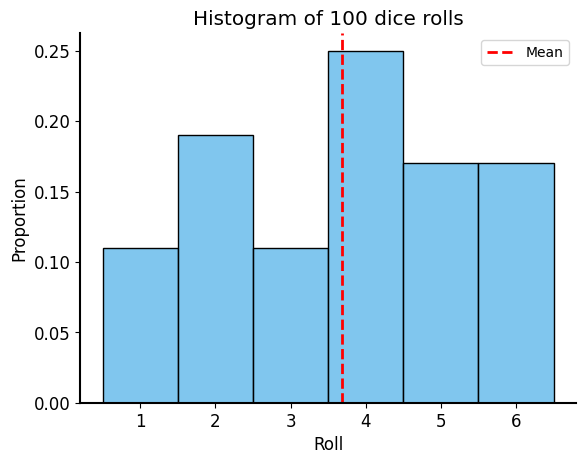

In [104]:
# plot histogram of 100 rolls of a die
np.random.seed(42)  # for reproducibility
rolls = pd.DataFrame({'roll': np.random.randint(1, 7, 100)})

sns.histplot(data=rolls, x='roll', bins=6, discrete=True, edgecolor="black", stat='proportion')
plt.axvline(x=rolls['roll'].mean(), color='red', linestyle='--', label='Mean')
plt.title("Histogram of 100 dice rolls")
plt.xlabel("Roll")
plt.legend()
plt.show()


But what happens if we average the values of the 100 dice rolls in our sample? We can simulate this process many times (roll a dice 100 times, take the average, repeat) to get a distribution of the average. 

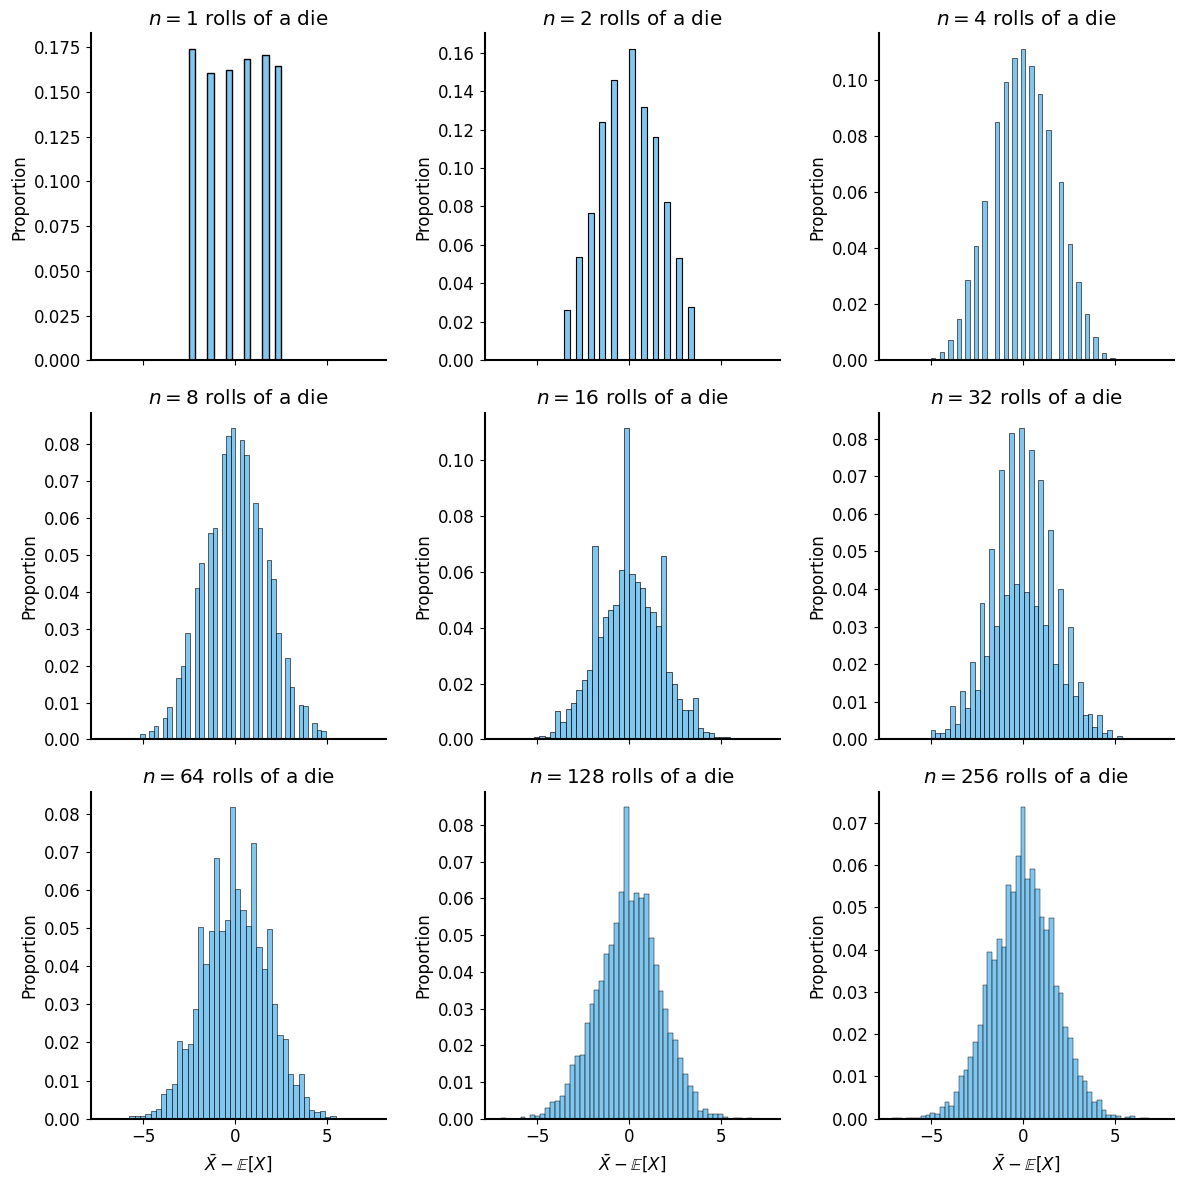

In [139]:
np.random.seed(42)  # for reproducibility
fig, ax = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=False)
ax = ax.flatten()

for i, n in enumerate([1, 2, 4, 8, 16, 32, 64, 128, 256]):
    # Simulate (5000 times) rolling a die n times and taking the average
    sum_rolls_data = (np.random.randint(1, 7, size=(5000, n)).mean(axis=1) - 3.5) * np.sqrt(n)  # Centering around the mean (3.5) and scaling by sqrt(n)
    sum_rolls = pd.DataFrame({'sum_roll': sum_rolls_data})

    # Plot the histogram
    sns.histplot(data=sum_rolls, x='sum_roll', edgecolor="black", stat='proportion', ax=ax[i])
    ax[i].set_title(f"$n={n}$ rolls of a die")
    ax[i].set_xlabel(r"$\bar{X} - \mathbb{E}[X]$")
    ax[i].set_ylabel("Proportion")
plt.tight_layout()
plt.show()


As you can see the distribution of the sum is approximately normal! It has the mean we would expect (3.5) and clearly values are clustered symmetrically around the mean. 

For the purposes of the class it's not necessary to understand why this happens, just that it happens. To give a bit of intuition though, we basically think that with more samples distributions will starts to cluster around their means. 

Why is this useful? Well, the normal distribution is a well studied distribution with many useful properties. It is symmetric, easy to work with mathematically, and is useful for approximating the distribution of many real-world processes. The normal distribution is decently good description of most data that clusters around its mean. 

The CLT tells us that even if we don't know the distribution of the individual variables, if we average enough of them together, we magically know the distribution of the sample mean.

Remember earlier in the lecture, we talked about how statistical models are useful as long as they are a faithful description of the outcome probabilities for a DGP? Well, the CLT gives us a guarantee that for a huge class of DGPs, we can use the normal distribution to model the sample mean.

